# Krypton waveform NB

## Imports

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-03-02 17:10:40


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [300]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pkf
import invisible_cities.reco.calib_sensors_functions as csf
from   invisible_cities.reco.xy_algorithms      import corona

from   invisible_cities.evm.ic_containers  import S12Params 
from   invisible_cities.evm.ic_containers  import CalibVectors
from   invisible_cities.evm.ic_containers  import DeconvParams
from   invisible_cities.evm.ic_containers  import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.core.core_functions import loc_elem_1d
from   invisible_cities.types.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.sierpe                 import blr

In [4]:
from invisible_cities.reco.dst_functions  import load_dst

In [5]:
from invisible_cities.evm .pmaps             import S1
from invisible_cities.evm .pmaps             import S2

In [115]:
from typing      import NamedTuple

## NB functions

In [7]:
def plot_S12(s12s):
    plt.grid(True)
    plt.xlabel(r't (ns)')
    plt.ylabel(r'q (pes)')
    for s12 in s12s:
        plt.plot(s12.times, s12.pmts.waveform(-1))

In [8]:
def plot_pmt_signals_vs_time_mus(pmt_signals,
                                 pmt_active,
                                 t_min      =    0,
                                 t_max      = 1200,
                                 signal_min =    0,
                                 signal_max =  200,
                                 figsize=(12,12)):
    """Plot PMT signals versus time in mus  and return figure."""

    tstep = 25
    PMTWL = pmt_signals[0].shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    plt.figure(figsize=figsize)
   
   
    plt.ylabel(r'q (pes/adc)')
    for j, i in enumerate(pmt_active):
        plt.grid(True)
        ax1 = plt.subplot(3, 4, j+1)
        ax1.set_xlim([t_min, t_max])
        ax1.set_ylim([signal_min, signal_max])
        plt.plot(signal_t, pmt_signals[i])
        plt.xlabel(r't (mus)')


In [9]:
def plot_pmt_waveforms(pmtwfdf, first=0, last=50000, figsize=(10,10)):
    """plot PMT wf and return figure"""
    plt.figure(figsize=figsize)
    for i in range(len(pmtwfdf)):
        ax = plt.subplot(3, 4, i+1)
        plt.xlabel(r't (mus)')
        plt.plot(pmtwfdf[i][first:last])


In [63]:
def display_s12s(s12s):
    for s12 in s12s:
        print('energy = {} pes charge = {} pes time = {} mus width = {} ns'.format(
        s12.total_energy, s12.total_charge, s12.time_at_max_energy/units.mus, s12.width))

In [400]:
def sort_s12s(s12s):
    return sorted(s12s, key= lambda s12 : s12.total_energy, reverse=True)

In [425]:
def kr_dst(s1s, s2s, xs, ys):
    s1 = sort_s12s(s1s)[0]
    s2 = sort_s12s(s2s)[0]
    c = compute_xy_peak_position(s2.sipms, xs, ys)
    
    return KrDst(es1 = s1.total_energy, ws1=s1.width, 
                 es2 =s2.total_energy,  ws2=s1.width, qs2=s2.total_charge, 
                 dt = (s2.time_at_max_energy - s1.time_at_max_energy) / units.mus,
                 c = c)
    

In [84]:
def plot_sipm_signals_vs_time_mus(sipm_signals,
                                  sipm_min      =    0,
                                  sipm_max      = 2000,
                                 figsize=(6,6)):
    """Plot PMT signals versus time in mus  and return figure."""


    plt.figure(figsize=figsize)   
    plt.ylabel(r'q (pes/adc)')
    plt.xlabel(r'sipm number ')
    ax = plt.subplot()
    ax.set_xlim([sipm_min, min(sipm_max, len(sipm_signals))])
    plt.grid(True)
    plt.plot(sipm_signals)
       


In [311]:
class Cluster(NamedTuple):
    Q     : float
    x     : float 
    y     : float
    nsipm : int

In [328]:
class KrDst(NamedTuple):
    es1  : float
    ws1  : float
    es2  : float
    ws2  : float
    qs2  : float
    dt   : float 
    c    : Cluster


In [318]:
def compute_xy_peak_position(sr, xs, ys):
        """
        Computes position using the integral of the charge
        in each SiPM. Config parameters set equal to the standard kDST values.
        """
        IDs = sr.ids
        Qs = sr.sum_over_times
        xs, ys   = xs[IDs], ys[IDs]
        cls      = corona(np.stack((xs, ys), axis=1), Qs,
                      Qthr           =  1.,
                      Qlm            =  0.,
                      lm_radius      =  -1.,
                      new_lm_radius  =  -1.,
                      msipm          =  1)
        c = cls[0]
        return Cluster(Q=c.Q, x=c._xy.x, y=c._xy.y, nsipm=c.nsipm)


In [403]:
KR = []

## Data base

In [404]:
run_number = 5176
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [405]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [406]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,0,PMT1,1,-23.9414,65.7785,0.000530,4.250400e-07,27.346,0.77,11.551
1,1,12,PMT3,1,-44.9951,-53.6231,0.000533,3.599900e-07,28.257,0.00,12.848
2,2,1,PMT2,1,68.9365,-12.1554,0.000530,5.525500e-07,29.983,0.81,12.072
3,3,13,PMT4,1,0.0000,185.0000,0.000526,3.563900e-07,30.131,0.00,12.006
4,4,19,PMTC,1,-118.9160,141.7180,0.000520,3.804100e-07,36.064,0.75,13.448
5,5,18,PMTB,1,-182.1890,32.1249,0.000529,5.704900e-07,26.945,0.75,9.687
6,6,7,PMTA,1,-160.2150,-92.5000,0.000518,5.597400e-07,31.032,0.00,11.675
7,7,6,PMT9,1,-63.2737,-173.8430,0.000528,5.918400e-07,40.055,0.00,15.462
8,8,2,PMT8,1,63.2737,-173.8430,0.000525,4.849600e-07,28.566,0.00,11.466
9,9,16,PMT7,1,160.2150,-92.5000,0.000527,4.763500e-07,0.000,0.00,0.000


In [20]:
channel_id

array([ 0, 12,  1, 13, 19, 18,  7,  6,  2, 16,  5,  4])

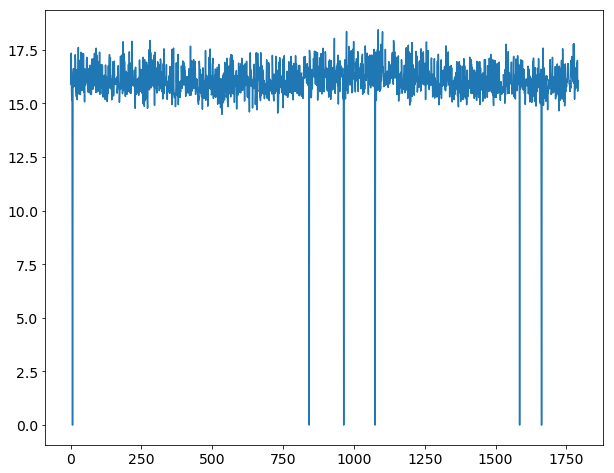

In [261]:
plt.plot(DataSiPM.adc_to_pes)

In [262]:
sipm_adc_to_pes = DataSiPM.adc_to_pes.values

In [263]:
sipm_adc_to_pes[181] = 0

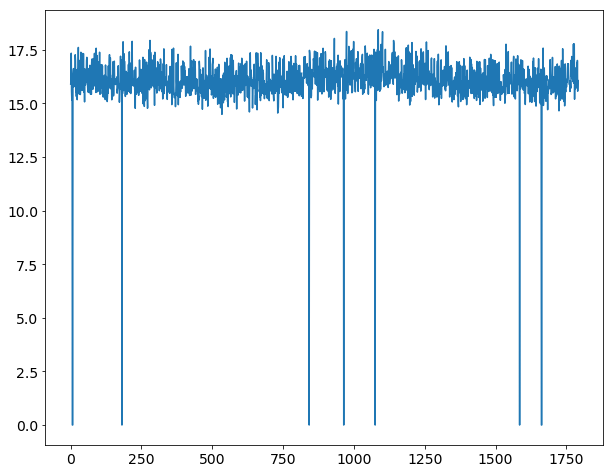

In [264]:
plt.plot(sipm_adc_to_pes)

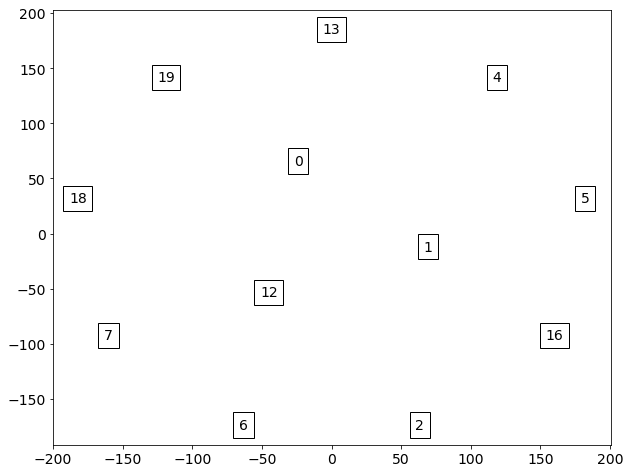

In [21]:
mpl.draw_pmt_map(run_number)

In [23]:
adc_to_pes

array([ 27.346,  28.257,  29.983,  30.131,  36.064,  26.945,  31.032,
        40.055,  28.566,   0.   ,  26.082,  27.499])

In [443]:
adc_to_pes[9] = 25

In [444]:
adc_to_pes

array([ 27.346,  28.257,  29.983,  30.131,  36.064,  26.945,  31.032,
        40.055,  28.566,  25.   ,  26.082,  27.499])

## Input file

In [454]:
filename = '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5176_0063_waveforms.h5'
input_files = [filename]
h5rwf = tb.open_file(filename, "r") 

In [455]:
pmtrwf = h5rwf.root.RD.pmtrwf
sipmrwf = h5rwf.root.RD.sipmrwf
NEVT, NPMT, PMTWL = pmtrwf.shape
_, NSIPM, SIPMWL = sipmrwf.shape

In [456]:
NEVT, NPMT, PMTWL = pmtrwf.shape

In [457]:
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL, NSIPM, SIPMWL))


        Number of events in file = 164
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


## S1 and S2 parameters

In [458]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)

In [459]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)

## Events

### Event

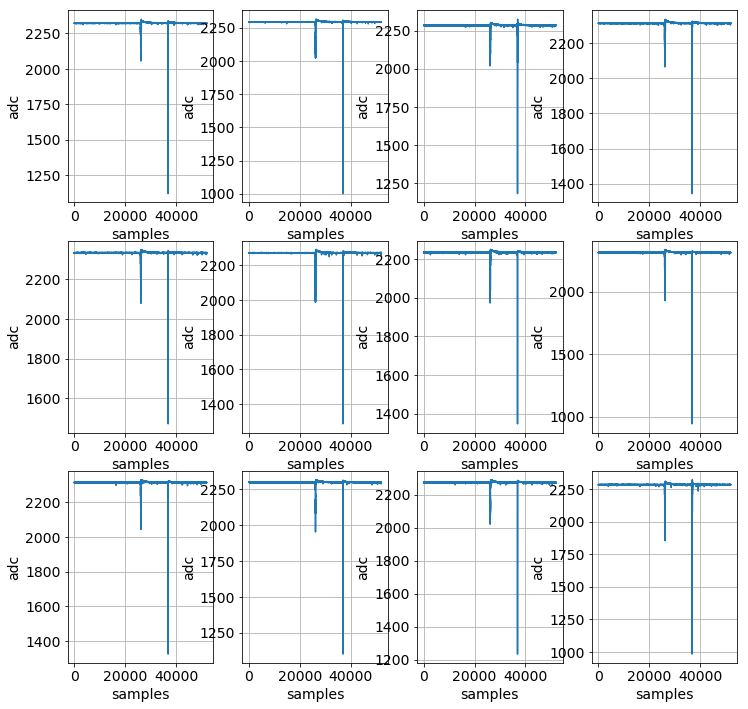

In [460]:
event=1
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

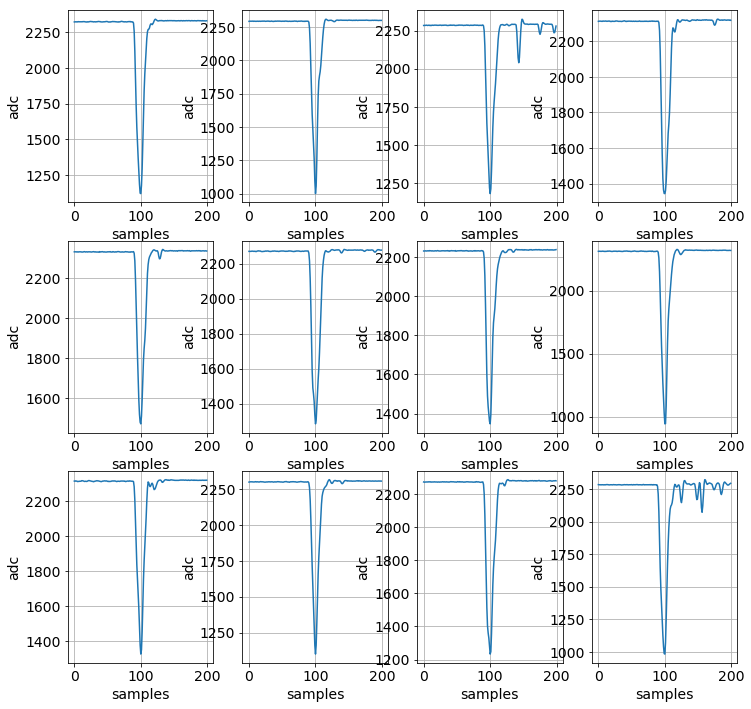

In [461]:
sf.plot_pmt_waveforms(pmtrwf[event], zoom=True, window_size=100, figsize=(12,12))

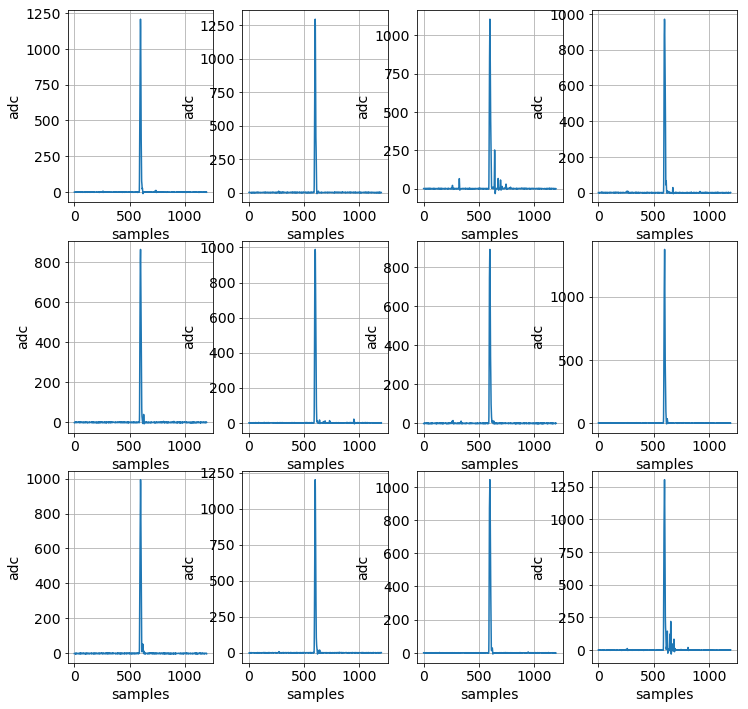

In [462]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=600, figsize=(12,12))

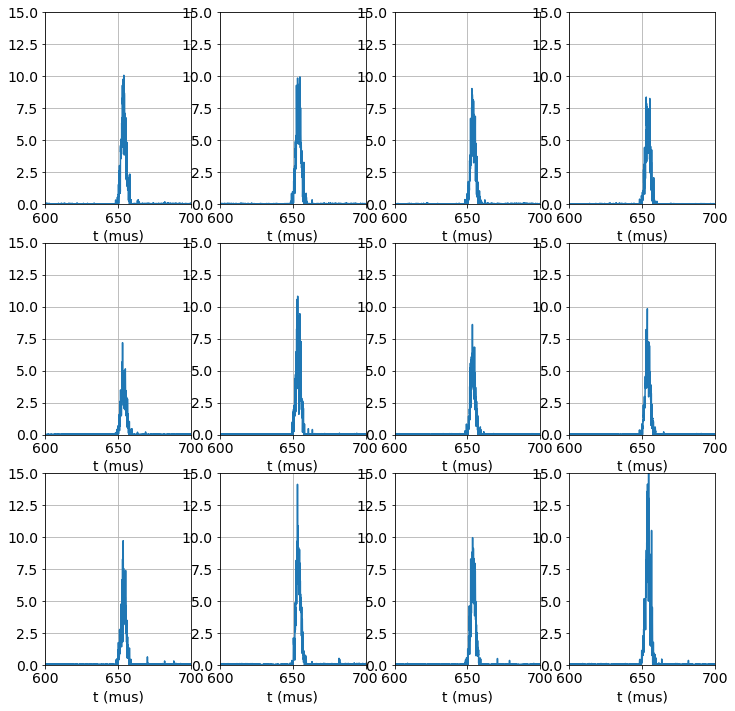

In [463]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    600,
                                t_max      = 700,
                                signal_min =    0,
                                signal_max =  15,
                                 figsize=(12,12))

- Calibrated sum

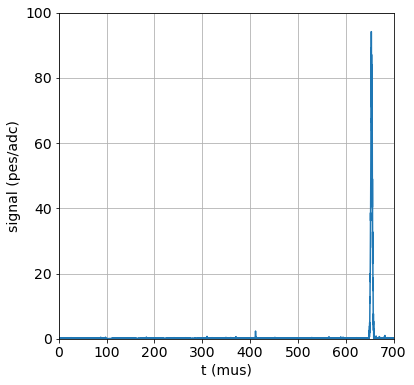

In [464]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

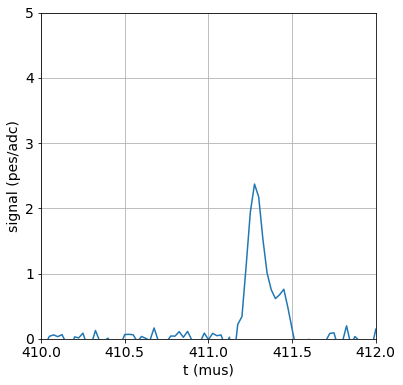

In [465]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =410,
                            t_max      = 412,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

- The structure appears also in individual PMTs. 

### SiPMs

In [466]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
sipm_sums = np.sum(np.where(sipm_cal > 2, sipm_cal, 0), axis=1)

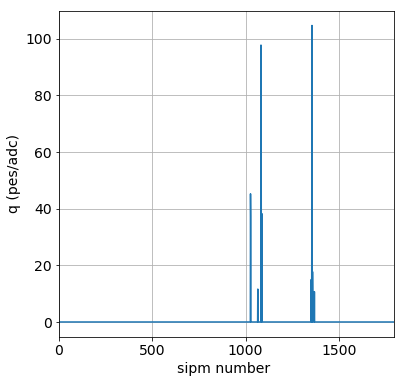

In [467]:
plot_sipm_signals_vs_time_mus(sipm_sums)

#### Search for S1 and S2a

In [468]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 10
       Times: [ 411.225  411.25   411.275  411.3    411.325  411.35   411.375  411.4
 411.425  411.45 ] µs
       Time @ max energy: 411.275
       Width: 0.225 µs
       Height: 2.372112743592805 pes
       Energy: 12.946851704767822 pes
       Charge: 0.0 pes
       RMS: 0.0633957649628953 µs]

In [469]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 12
       Times: [ 648.47715957  649.61887863  650.62541102  651.56715821  652.54719015
 653.48823094  654.47978211  655.42935154  656.41910144  657.36642767
 658.48331713  659.22911764] µs
       Time @ max energy: 653.4882309350783
       Width: 10.75195806937886 µs
       Height: 3264.669041780416 pes
       Energy: 13616.96071017916 pes
       Charge: 334.3799754932642 pes
       RMS: 1.617869213555822 µs]

In [470]:
c = compute_xy_peak_position(s2s[0].sipms, xs, ys)
c

Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7)

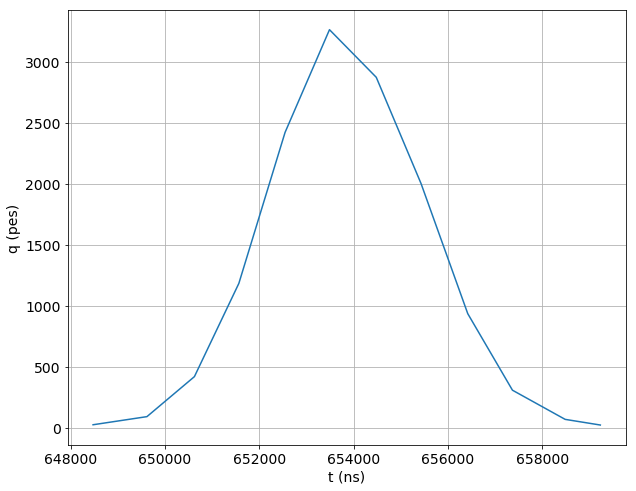

In [471]:
plot_S12(s2s)

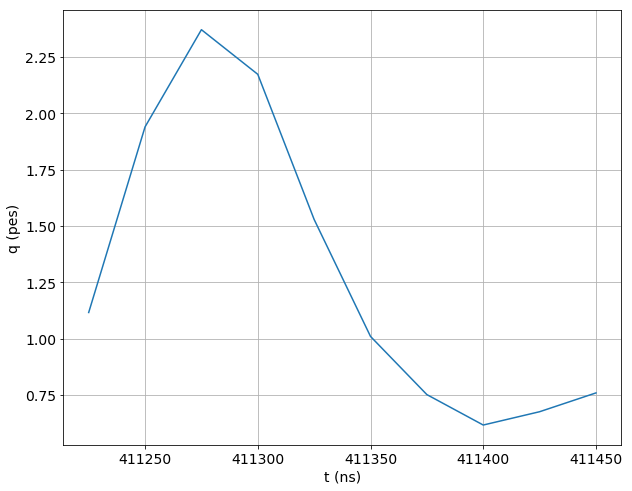

In [472]:
plot_S12(s1s)

In [473]:
kr_dst(s1s, s2s, xs, ys)

KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7))

In [474]:
KR=[]
KR.append(kr_dst(s1s, s2s, xs, ys))

In [475]:
KR

[KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7))]

### Event

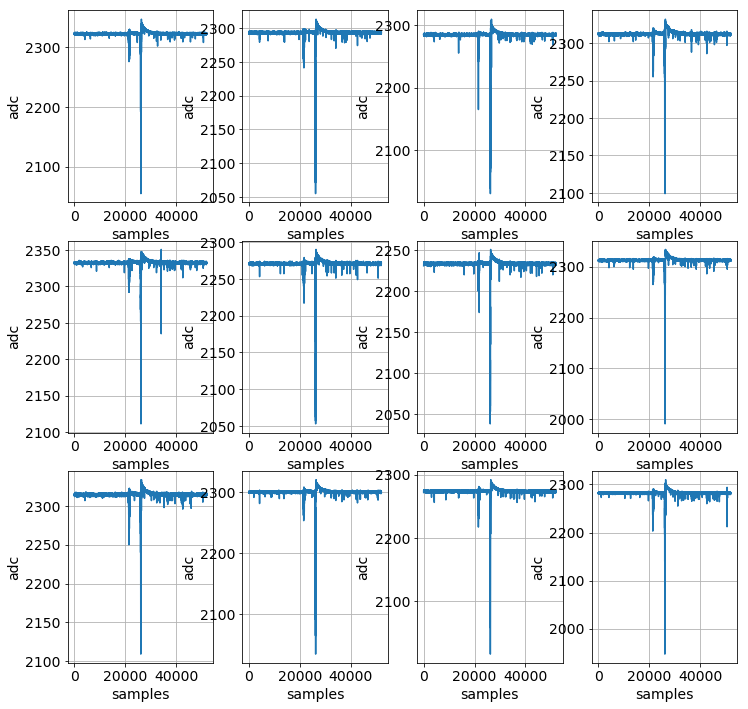

In [476]:
event=2
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

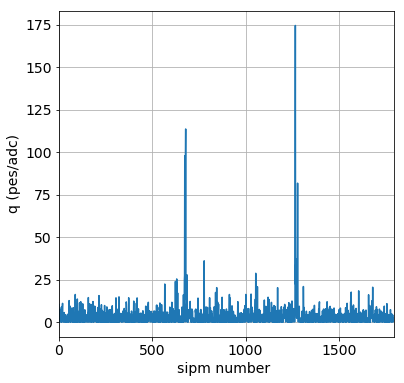

In [477]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=2,
                          bls_mode=csf.BlsMode.mode)
sipm_sums = np.sum(np.where(sipm_cal > 2, sipm_cal, 0), axis=1)
plot_sipm_signals_vs_time_mus(sipm_sums,
                              sipm_min =    0,
                              sipm_max =  2000)

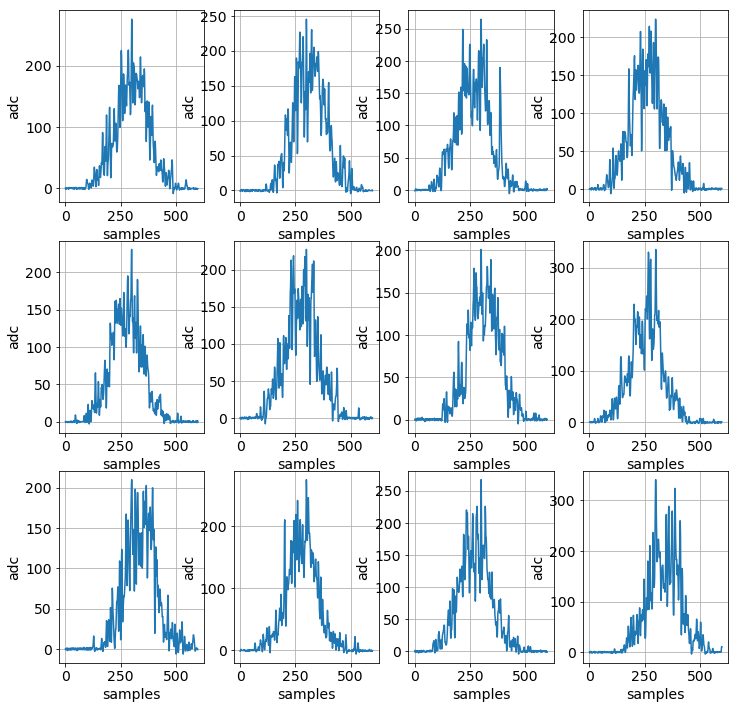

In [478]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=300, figsize=(12,12))

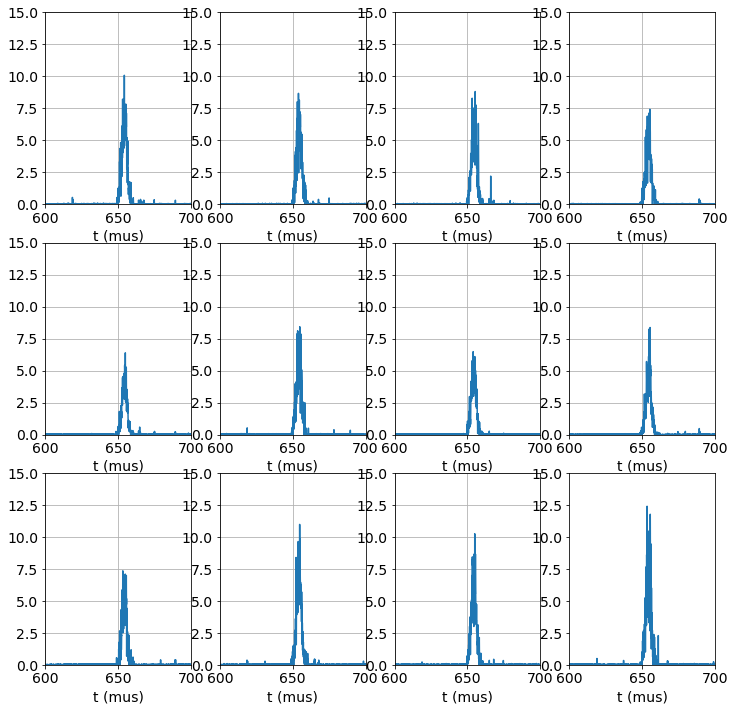

In [479]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    600,
                                t_max      = 700,
                                signal_min =    0,
                                signal_max =  15,
                                 figsize=(12,12))

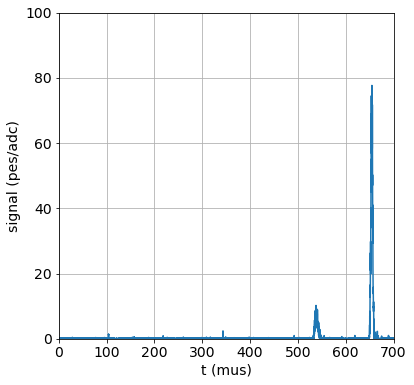

In [480]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

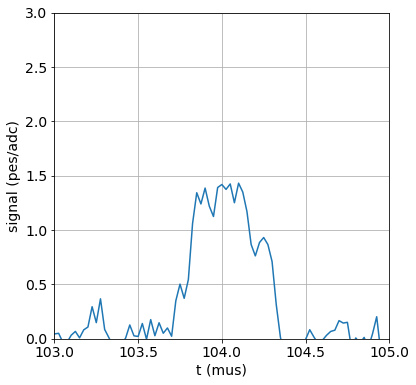

In [484]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =103,
                            t_max      = 105,
                            signal_min =    0,
                            signal_max =  3,
                            figsize=(6,6))

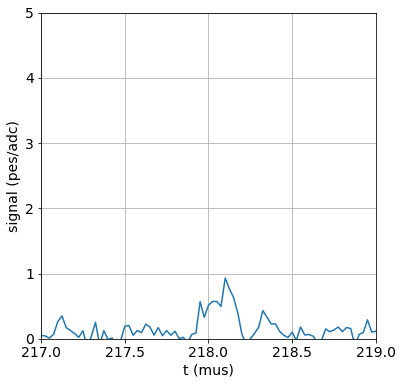

In [485]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =217,
                            t_max      = 219,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

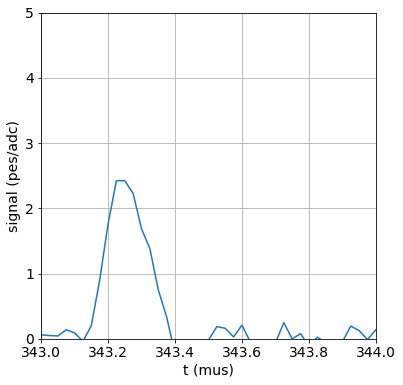

In [487]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =343,
                            t_max      = 344,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

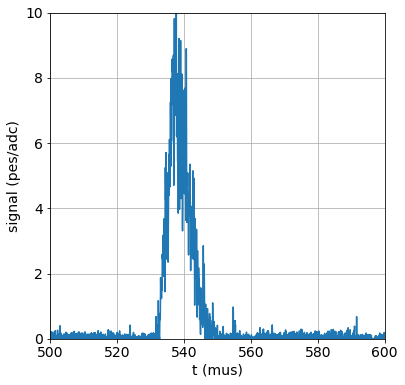

In [488]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =500,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [489]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 23
       Times: [ 103.75   103.775  103.8    103.825  103.85   103.875  103.9    103.925
 103.95   103.975  104.     104.025  104.05   104.075  104.1    104.125
 104.15   104.175  104.2    104.225  104.25   104.275  104.3  ] µs
       Time @ max energy: 104.1
       Width: 0.55 µs
       Height: 1.4314424440182019 pes
       Energy: 24.63214318046156 pes
       Charge: 0.0 pes
       RMS: 0.14556454076919695 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 218.075  218.1    218.125  218.15 ] µs
 Time @ max energy: 218.1
 Width: 0.075 µs
 Height: 0.9321324805586895 pes
 Energy: 2.8261396072965352 pes
 Charge: 0.0 pes
 RMS: 0.025589167503598863 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 9
       Times: [ 343.175  343.2    343.225  343.25   343.275  343.3    343.325  343.35


In [495]:
s2params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 15
       Times: [ 532.67807374  533.5462537   534.51461038  535.52644476  536.50476091
 537.48689936  538.49496115  539.46684323  540.47824633  541.48484642
 542.49525628  543.44404755  544.39014362  545.53679246  546.18183919] µs
       Time @ max energy: 537.4868993570086
       Width: 13.503765441049472 µs
       Height: 314.58515174307564 pes
       Energy: 2283.2271586500265 pes
       Charge: 625.2336448660035 pes
       RMS: 2.988162512094102 µs, 
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 648.94501564  649.67201979  650.58706252  651.54751121  652.55141159
 653.48470219  654.50813448  655.46262249  656.40624883  657.43153644
 658.38145082  659.25855188  660.41725764  661.09210834] µs
       Time @ max energy: 654.508134481122
       Width: 12.14709269673191 µs
       Height: 2676.0579152028045 pe

In [496]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 520 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 23
       Times: [ 103.75   103.775  103.8    103.825  103.85   103.875  103.9    103.925
 103.95   103.975  104.     104.025  104.05   104.075  104.1    104.125
 104.15   104.175  104.2    104.225  104.25   104.275  104.3  ] µs
       Time @ max energy: 104.1
       Width: 0.55 µs
       Height: 1.4314424440182019 pes
       Energy: 24.63214318046156 pes
       Charge: 0.0 pes
       RMS: 0.14556454076919695 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 218.075  218.1    218.125  218.15 ] µs
 Time @ max energy: 218.1
 Width: 0.075 µs
 Height: 0.9321324805586895 pes
 Energy: 2.8261396072965352 pes
 Charge: 0.0 pes
 RMS: 0.025589167503598863 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 9
       Times: [ 343.175  343.2    343.225  343.25   343.275  343.3    343.325  343.35


In [492]:
kr_dst(s1s, s2s, xs, ys)

KrDst(es1=24.632143180461561, ws1=550.0, es2=12732.169696089704, ws2=550.0, qs2=806.98207636866016, dt=550.40813448112203, c=Cluster(Q=806.98207636866016, x=-20.280406837189968, y=53.111025479487076, nsipm=83))

In [493]:
KR.append(kr_dst(s1s, s2s, xs, ys))

In [494]:
KR

[KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7)),
 KrDst(es1=24.632143180461561, ws1=550.0, es2=12732.169696089704, ws2=550.0, qs2=806.98207636866016, dt=550.40813448112203, c=Cluster(Q=806.98207636866016, x=-20.280406837189968, y=53.111025479487076, nsipm=83))]

### Event

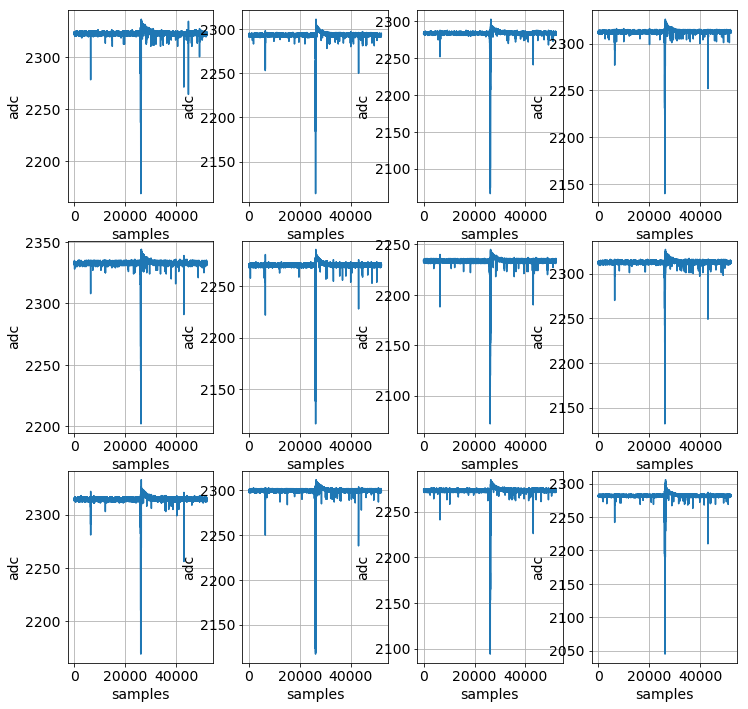

In [497]:
event=3
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

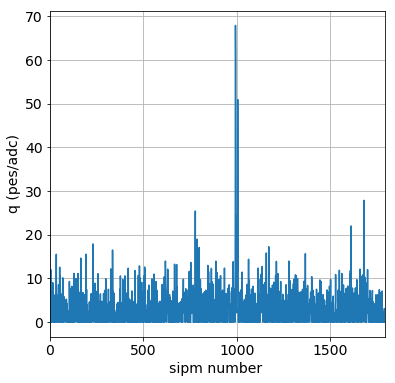

In [498]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=2,
                          bls_mode=csf.BlsMode.mode)
sipm_sums = np.sum(np.where(sipm_cal > 2, sipm_cal, 0), axis=1)
plot_sipm_signals_vs_time_mus(sipm_sums,
                              sipm_min =    0,
                              sipm_max =  2000)

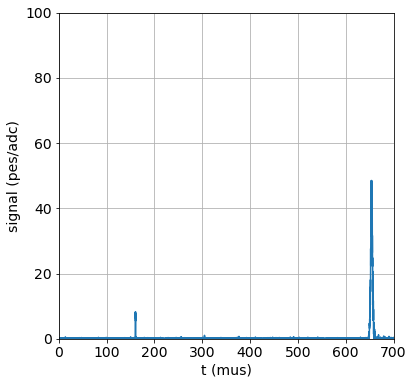

In [499]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

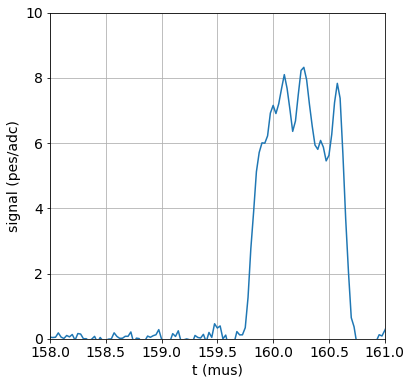

In [354]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =158,
                            t_max      = 161,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

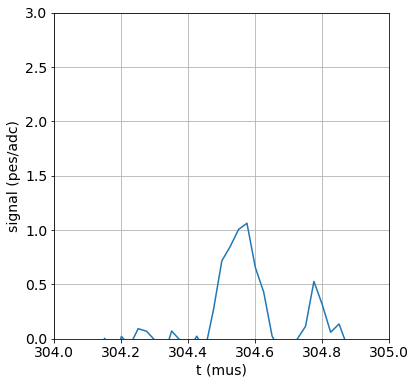

In [360]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =304,
                            t_max      = 305,
                            signal_min =    0,
                            signal_max =  3,
                            figsize=(6,6))

In [503]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 304.5    304.525  304.55   304.575  304.6  ] µs
 Time @ max energy: 304.575
 Width: 0.1 µs
 Height: 1.0629535134821402 pes
 Energy: 4.292264169883765 pes
 Charge: 0.0 pes
 RMS: 0.032836604452275216 µs]

In [504]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 13
       Times: [ 648.62065771  649.60481305  650.54890407  651.54131391  652.5332682
 653.4942681   654.47731727  655.44586968  656.42755803  657.44185608
 658.43844761  659.32265641  660.36353326] µs
       Time @ max energy: 653.4942680998305
       Width: 11.742875543442905 µs
       Height: 1678.4239343684712 pes
       Energy: 8267.510074992084 pes
       Charge: 476.12195218014847 pes
       RMS: 1.925571718512162 µs]

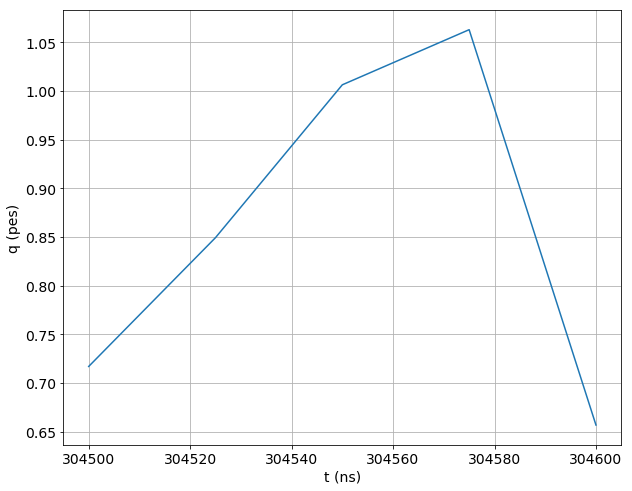

In [505]:
plot_S12(s1s)

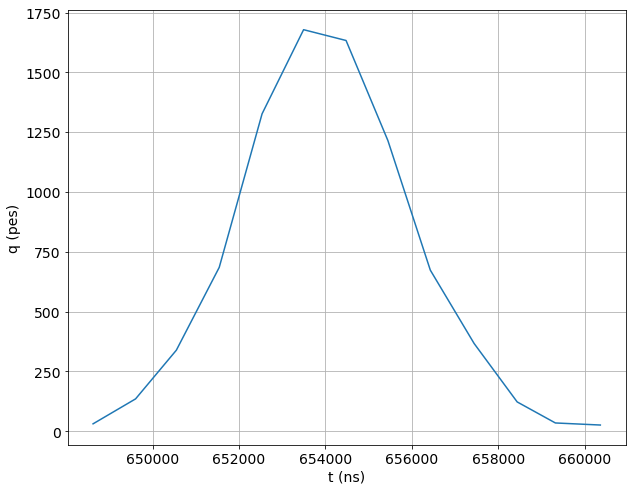

In [506]:
plot_S12(s2s)

In [507]:
KR.append(kr_dst(s1s, s2s, xs, ys))

In [508]:
KR

[KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7)),
 KrDst(es1=24.632143180461561, ws1=550.0, es2=12732.169696089704, ws2=550.0, qs2=806.98207636866016, dt=550.40813448112203, c=Cluster(Q=806.98207636866016, x=-20.280406837189968, y=53.111025479487076, nsipm=83)),
 KrDst(es1=4.2922641698837651, ws1=100.0, es2=8267.5100749920839, ws2=100.0, qs2=476.12195218014847, dt=348.9192680998305, c=Cluster(Q=476.12195218014841, x=35.619749348227387, y=96.227390320957241, nsipm=65))]

### Event

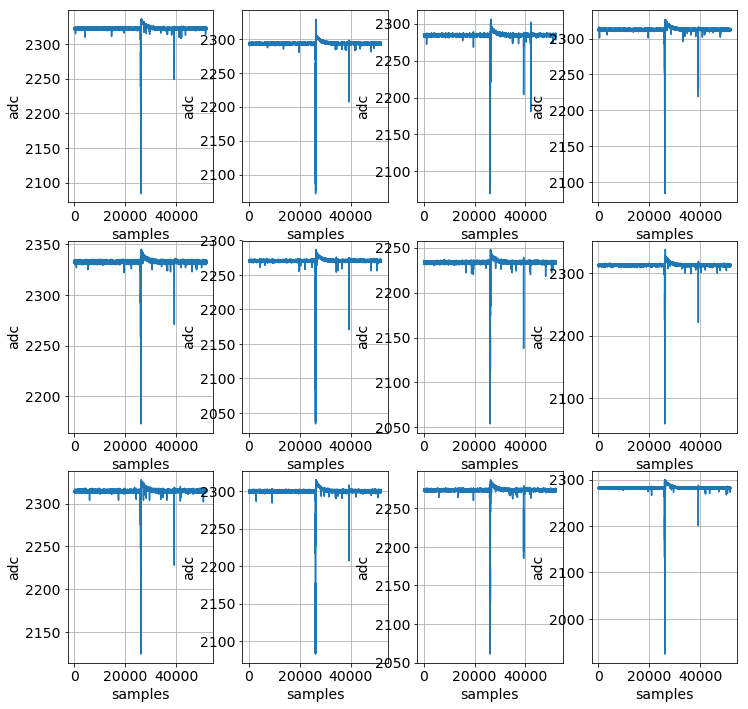

In [509]:
event=4
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

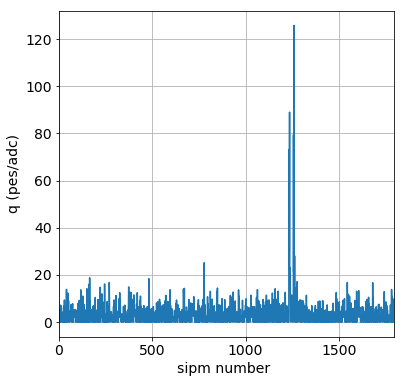

In [510]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=2,
                          bls_mode=csf.BlsMode.mode)
sipm_sums = np.sum(np.where(sipm_cal > 2, sipm_cal, 0), axis=1)
plot_sipm_signals_vs_time_mus(sipm_sums,
                              sipm_min =    0,
                              sipm_max =  2000)

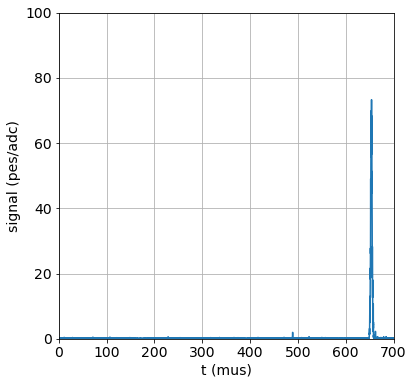

In [511]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

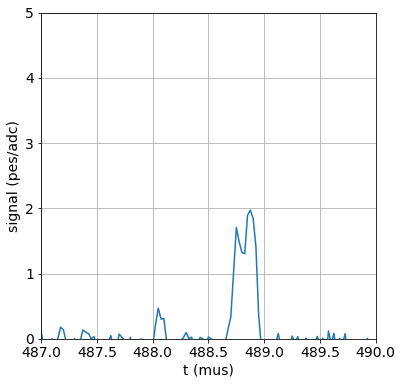

In [512]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =487,
                            t_max      = 490,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [516]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 10
       Times: [ 488.725  488.75   488.775  488.8    488.825  488.85   488.875  488.9
 488.925  488.95 ] µs
       Time @ max energy: 488.875
       Width: 0.225 µs
       Height: 1.9731925437365152 pes
       Energy: 14.326128761767084 pes
       Charge: 0.0 pes
       RMS: 0.06432507528614066 µs]

In [514]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 10
       Times: [ 649.63362039  650.54850098  651.55573711  652.52066411  653.48642954
 654.44393964  655.41298511  656.37758429  657.42673952  658.20264763] µs
       Time @ max energy: 653.4864295387321
       Width: 8.569027239356888 µs
       Height: 2582.166792220901 pes
       Energy: 9957.67149598382 pes
       Charge: 745.6633791330878 pes
       RMS: 1.4837325972309259 µs]

In [515]:
KR.append(kr_dst(s1s, s2s, xs, ys))
KR

[KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7)),
 KrDst(es1=24.632143180461561, ws1=550.0, es2=12732.169696089704, ws2=550.0, qs2=806.98207636866016, dt=550.40813448112203, c=Cluster(Q=806.98207636866016, x=-20.280406837189968, y=53.111025479487076, nsipm=83)),
 KrDst(es1=4.2922641698837651, ws1=100.0, es2=8267.5100749920839, ws2=100.0, qs2=476.12195218014847, dt=348.9192680998305, c=Cluster(Q=476.12195218014841, x=35.619749348227387, y=96.227390320957241, nsipm=65)),
 KrDst(es1=14.326128761767084, ws1=225.0, es2=9957.6714959838191, ws2=225.0, qs2=745.6633791330878, dt=164.61142953873204, c=Cluster(Q=745.66337913308757, x=32.983391130106178, y=-180.43350651934065, nsipm=78))]

### Event

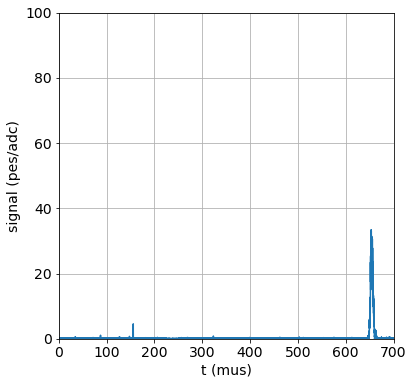

In [517]:
event=5
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

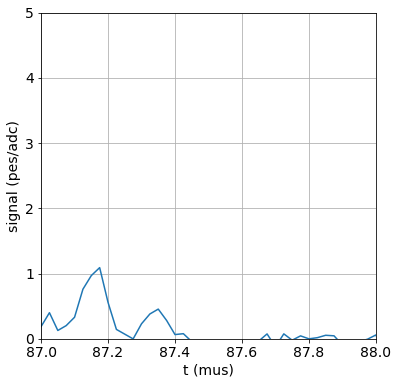

In [518]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =87,
                            t_max      = 88,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

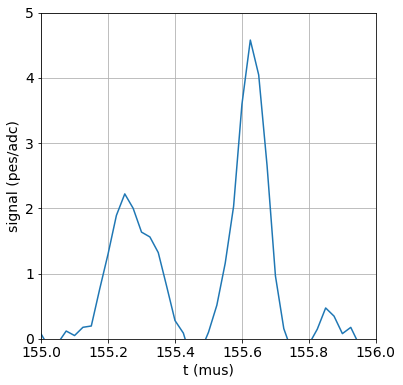

In [519]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =155,
                            t_max      = 156,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

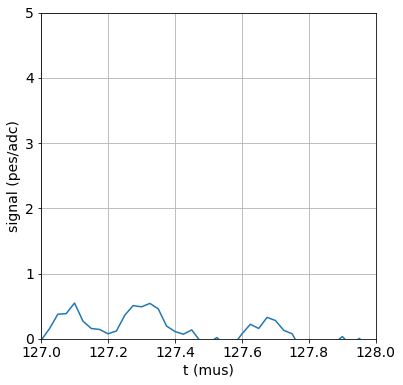

In [520]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =127,
                            t_max      = 128,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [521]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 8,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 87.125  87.15   87.175  87.2  ] µs
 Time @ max energy: 87.175
 Width: 0.075 µs
 Height: 1.0911822128890243 pes
 Energy: 3.3784317357414837 pes
 Charge: 0.0 pes
 RMS: 0.025314113938426697 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 12
       Times: [ 127.075  127.1    127.125  127.15   127.175  127.2    127.225  127.25
 127.275  127.3    127.325  127.35 ] µs
       Time @ max energy: 127.1
       Width: 0.275 µs
       Height: 0.5480761760908409 pes
       Energy: 4.06440221421999 pes
       Charge: 0.0 pes
       RMS: 0.09680212732453966 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 22
       Times: [ 155.175  155.2    155.225  155.25   155.275  155.3    155.325  155.35
 155.375  155.4    155.425  155.45   155.475  155.5    155.525  155.55
 155.575  155.6    155.625  155

In [522]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 15
       Times: [ 647.83811877  648.53529271  649.55439087  650.53310489  651.56278518
 652.51539785  653.46901588  654.45780757  655.49124196  656.47532164
 657.44900157  658.41919057  659.32919707  660.5767129   661.08465232] µs
       Time @ max energy: 653.4690158846115
       Width: 13.246533550074673 µs
       Height: 1079.570796226346 pes
       Energy: 6930.029312746013 pes
       Charge: 764.2078722836386 pes
       RMS: 2.3381366955723046 µs]

In [523]:
KR.append(kr_dst(s1s, s2s, xs, ys))
KR

[KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7)),
 KrDst(es1=24.632143180461561, ws1=550.0, es2=12732.169696089704, ws2=550.0, qs2=806.98207636866016, dt=550.40813448112203, c=Cluster(Q=806.98207636866016, x=-20.280406837189968, y=53.111025479487076, nsipm=83)),
 KrDst(es1=4.2922641698837651, ws1=100.0, es2=8267.5100749920839, ws2=100.0, qs2=476.12195218014847, dt=348.9192680998305, c=Cluster(Q=476.12195218014841, x=35.619749348227387, y=96.227390320957241, nsipm=65)),
 KrDst(es1=14.326128761767084, ws1=225.0, es2=9957.6714959838191, ws2=225.0, qs2=745.6633791330878, dt=164.61142953873204, c=Cluster(Q=745.66337913308757, x=32.983391130106178, y=-180.43350651934065, nsipm=78)),
 KrDst(es1=33.509276513120163, ws1=525.0, es2=6930.0293127460127, ws2=525.0, qs2=764.20787228363861, dt=497.84401588461151, c=Cluster(Q=764.2078722836386

### Event

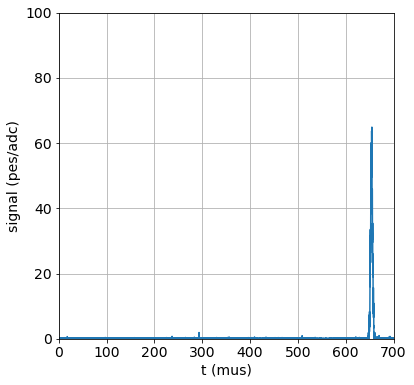

In [524]:
event=6
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

In [526]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 13
       Times: [ 293.15   293.175  293.2    293.225  293.25   293.275  293.3    293.325
 293.35   293.375  293.4    293.425  293.45 ] µs
       Time @ max energy: 293.2
       Width: 0.3 µs
       Height: 1.922300732527514 pes
       Energy: 14.991139414589993 pes
       Charge: 0.0 pes
       RMS: 0.08328176908207967 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 508.65   508.675  508.7    508.725] µs
 Time @ max energy: 508.7
 Width: 0.075 µs
 Height: 0.9467145956870029 pes
 Energy: 3.192237938862532 pes
 Charge: 0.0 pes
 RMS: 0.026706712919592677 µs]

In [529]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 15
       Times: [ 647.46895003  648.57071047  649.48790024  650.61788121  651.48982228
 652.52051638  653.50530147  654.45624696  655.4656874   656.4409958
 657.46728913  658.3142366   659.43702284  660.37343035  661.02491718] µs
       Time @ max energy: 654.4562469584517
       Width: 13.555967155066202 µs
       Height: 2205.9797062890448 pes
       Energy: 11178.319253273421 pes
       Charge: 764.2078722836386 pes
       RMS: 2.0052139673852696 µs]

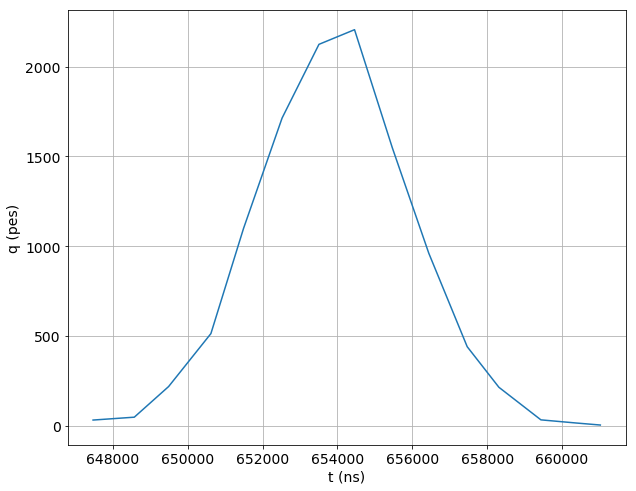

In [530]:
plot_S12(s2s)

In [531]:
KR.append(kr_dst(s1s, s2s, xs, ys))
KR

[KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7)),
 KrDst(es1=24.632143180461561, ws1=550.0, es2=12732.169696089704, ws2=550.0, qs2=806.98207636866016, dt=550.40813448112203, c=Cluster(Q=806.98207636866016, x=-20.280406837189968, y=53.111025479487076, nsipm=83)),
 KrDst(es1=4.2922641698837651, ws1=100.0, es2=8267.5100749920839, ws2=100.0, qs2=476.12195218014847, dt=348.9192680998305, c=Cluster(Q=476.12195218014841, x=35.619749348227387, y=96.227390320957241, nsipm=65)),
 KrDst(es1=14.326128761767084, ws1=225.0, es2=9957.6714959838191, ws2=225.0, qs2=745.6633791330878, dt=164.61142953873204, c=Cluster(Q=745.66337913308757, x=32.983391130106178, y=-180.43350651934065, nsipm=78)),
 KrDst(es1=33.509276513120163, ws1=525.0, es2=6930.0293127460127, ws2=525.0, qs2=764.20787228363861, dt=497.84401588461151, c=Cluster(Q=764.2078722836386

### Event

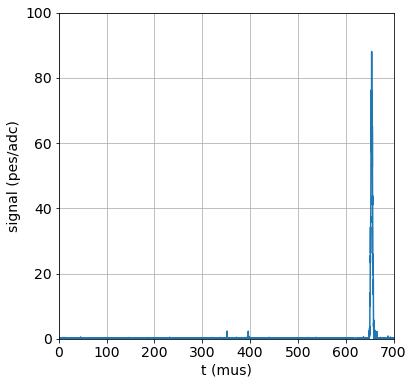

In [532]:
event=7
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

In [533]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 351.725  351.75   351.775  351.8    351.825  351.85   351.875] µs
 Time @ max energy: 351.775
 Width: 0.15 µs
 Height: 2.350194599835941 pes
 Energy: 11.107445250220055 pes
 Charge: 0.0 pes
 RMS: 0.04242874320284565 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 396.1    396.125  396.15   396.175  396.2  ] µs
 Time @ max energy: 396.125
 Width: 0.1 µs
 Height: 2.353646098813171 pes
 Energy: 8.426380497178053 pes
 Charge: 0.0 pes
 RMS: 0.029406617173807645 µs]

In [534]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 13
       Times: [ 648.8091362   649.62837211  650.61898469  651.52884664  652.55493979
 653.49184787  654.45942299  655.46482857  656.42113197  657.40233072
 658.41941334  659.38606151  660.76366572] µs
       Time @ max energy: 654.4594229868903
       Width: 11.954529520267272 µs
       Height: 2657.9002731369383 pes
       Energy: 12903.052592351016 pes
       Charge: 760.8614535951772 pes
       RMS: 1.7650513622446333 µs]

In [535]:
KR.append(kr_dst(s1s, s2s, xs, ys))
KR

[KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7)),
 KrDst(es1=24.632143180461561, ws1=550.0, es2=12732.169696089704, ws2=550.0, qs2=806.98207636866016, dt=550.40813448112203, c=Cluster(Q=806.98207636866016, x=-20.280406837189968, y=53.111025479487076, nsipm=83)),
 KrDst(es1=4.2922641698837651, ws1=100.0, es2=8267.5100749920839, ws2=100.0, qs2=476.12195218014847, dt=348.9192680998305, c=Cluster(Q=476.12195218014841, x=35.619749348227387, y=96.227390320957241, nsipm=65)),
 KrDst(es1=14.326128761767084, ws1=225.0, es2=9957.6714959838191, ws2=225.0, qs2=745.6633791330878, dt=164.61142953873204, c=Cluster(Q=745.66337913308757, x=32.983391130106178, y=-180.43350651934065, nsipm=78)),
 KrDst(es1=33.509276513120163, ws1=525.0, es2=6930.0293127460127, ws2=525.0, qs2=764.20787228363861, dt=497.84401588461151, c=Cluster(Q=764.2078722836386

### Event

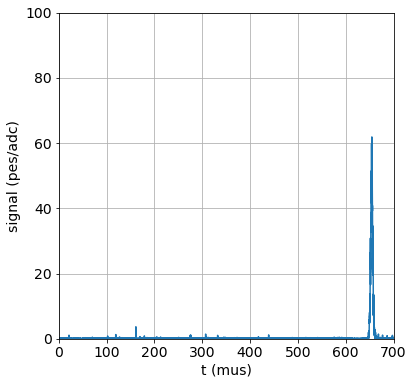

In [536]:
event=8
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

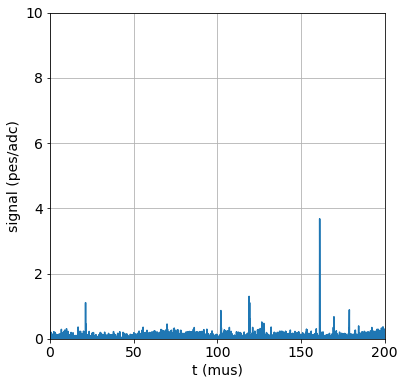

In [538]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 200,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [537]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 21.225  21.25   21.275  21.3    21.325] µs
 Time @ max energy: 21.275
 Width: 0.1 µs
 Height: 1.1085280305284486 pes
 Energy: 4.335388157200802 pes
 Charge: 0.0 pes
 RMS: 0.03175572013413857 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 102.025  102.05   102.075  102.1    102.125  102.15 ] µs
 Time @ max energy: 102.1
 Width: 0.125 µs
 Height: 0.8662584511696674 pes
 Energy: 3.997553978337569 pes
 Charge: 0.0 pes
 RMS: 0.040519082197627704 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 118.925  118.95   118.975  119.   ] µs
 Time @ max energy: 118.975
 Width: 0.075 µs
 Height: 1.3004571376072689 pes
 Energy: 3.6926957320828064 pes
 Charge: 0.0 pes
 RMS: 0.024659437694250257 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 119.175  119.2    119.225  11

In [539]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 16
       Times: [ 647.70615232  648.53999892  649.53697286  650.55468913  651.47601059
 652.53874704  653.50842001  654.47618522  655.45357689  656.47393144
 657.3878671   658.44185379  659.37998935  660.364191    661.47278205
 662.2359649 ] µs
       Time @ max energy: 653.5084200077895
       Width: 14.52981257629278 µs
       Height: 2059.9320537068193 pes
       Energy: 11017.007596567266 pes
       Charge: 766.2796137303061 pes
       RMS: 2.2030655404561723 µs]

In [540]:
KR.append(kr_dst(s1s, s2s, xs, ys))
KR

[KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7)),
 KrDst(es1=24.632143180461561, ws1=550.0, es2=12732.169696089704, ws2=550.0, qs2=806.98207636866016, dt=550.40813448112203, c=Cluster(Q=806.98207636866016, x=-20.280406837189968, y=53.111025479487076, nsipm=83)),
 KrDst(es1=4.2922641698837651, ws1=100.0, es2=8267.5100749920839, ws2=100.0, qs2=476.12195218014847, dt=348.9192680998305, c=Cluster(Q=476.12195218014841, x=35.619749348227387, y=96.227390320957241, nsipm=65)),
 KrDst(es1=14.326128761767084, ws1=225.0, es2=9957.6714959838191, ws2=225.0, qs2=745.6633791330878, dt=164.61142953873204, c=Cluster(Q=745.66337913308757, x=32.983391130106178, y=-180.43350651934065, nsipm=78)),
 KrDst(es1=33.509276513120163, ws1=525.0, es2=6930.0293127460127, ws2=525.0, qs2=764.20787228363861, dt=497.84401588461151, c=Cluster(Q=764.2078722836386

### Event

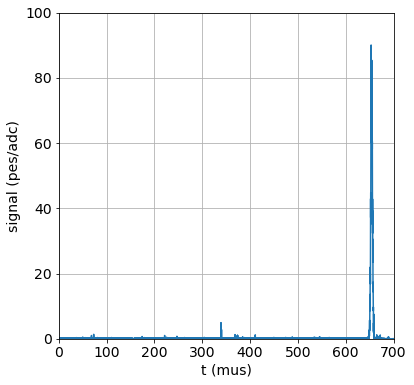

In [541]:
event=9
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

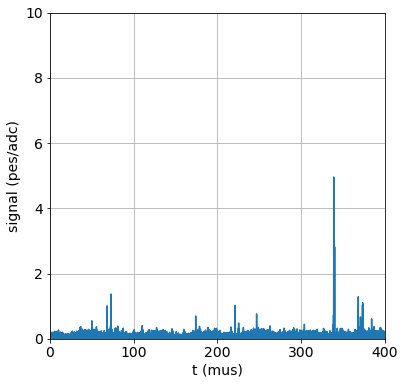

In [543]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 400,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

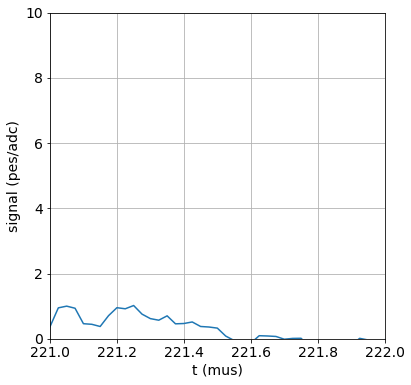

In [544]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =221,
                            t_max      = 222,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

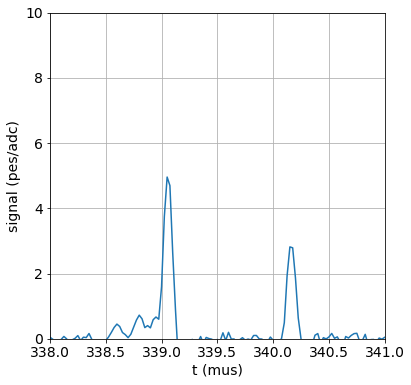

In [545]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =338,
                            t_max      = 341,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [542]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 68.175  68.2    68.225  68.25   68.275  68.3    68.325] µs
 Time @ max energy: 68.275
 Width: 0.15 µs
 Height: 1.008373657285313 pes
 Energy: 5.103973576818314 pes
 Charge: 0.0 pes
 RMS: 0.04492953495565861 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 72.85   72.875  72.9    72.925  72.95   72.975  73.   ] µs
 Time @ max energy: 72.9
 Width: 0.15 µs
 Height: 1.3745374987386343 pes
 Energy: 6.99960481728453 pes
 Charge: 0.0 pes
 RMS: 0.04360568785908381 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 19
       Times: [ 221.025  221.05   221.075  221.1    221.125  221.15   221.175  221.2
 221.225  221.25   221.275  221.3    221.325  221.35   221.375  221.4
 221.425  221.45   221.475] µs
       Time @ max energy: 221.25
       Width: 0.45 µs
       Height: 1.0200230121635738 pes
       En

In [546]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 12
       Times: [ 648.50702905  649.56408176  650.57931533  651.56823762  652.56209745
 653.47834799  654.46547866  655.43948876  656.42636196  657.35159598
 658.40626489  659.19346822] µs
       Time @ max energy: 654.4654786648244
       Width: 10.686439172560116 µs
       Height: 2944.331019640562 pes
       Energy: 13165.254107714476 pes
       Charge: 757.9757165042457 pes
       RMS: 1.7163718976893205 µs]

In [547]:
KR.append(kr_dst(s1s, s2s, xs, ys))
KR

[KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7)),
 KrDst(es1=24.632143180461561, ws1=550.0, es2=12732.169696089704, ws2=550.0, qs2=806.98207636866016, dt=550.40813448112203, c=Cluster(Q=806.98207636866016, x=-20.280406837189968, y=53.111025479487076, nsipm=83)),
 KrDst(es1=4.2922641698837651, ws1=100.0, es2=8267.5100749920839, ws2=100.0, qs2=476.12195218014847, dt=348.9192680998305, c=Cluster(Q=476.12195218014841, x=35.619749348227387, y=96.227390320957241, nsipm=65)),
 KrDst(es1=14.326128761767084, ws1=225.0, es2=9957.6714959838191, ws2=225.0, qs2=745.6633791330878, dt=164.61142953873204, c=Cluster(Q=745.66337913308757, x=32.983391130106178, y=-180.43350651934065, nsipm=78)),
 KrDst(es1=33.509276513120163, ws1=525.0, es2=6930.0293127460127, ws2=525.0, qs2=764.20787228363861, dt=497.84401588461151, c=Cluster(Q=764.2078722836386

### Event

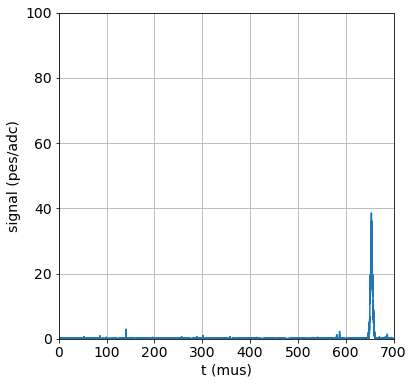

In [548]:
event=10
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

In [549]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 85.65   85.675  85.7    85.725  85.75   85.775] µs
 Time @ max energy: 85.725
 Width: 0.125 µs
 Height: 0.9509052043652192 pes
 Energy: 4.498613077453752 pes
 Charge: 0.0 pes
 RMS: 0.039212440761750345 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 140.6    140.625  140.65   140.675  140.7    140.725] µs
 Time @ max energy: 140.65
 Width: 0.125 µs
 Height: 2.953508364801877 pes
 Energy: 12.163112574237692 pes
 Charge: 0.0 pes
 RMS: 0.03579089864207895 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 288.35   288.375  288.4    288.425] µs
 Time @ max energy: 288.4
 Width: 0.075 µs
 Height: 0.6693171223583487 pes
 Energy: 1.9827032069933428 pes
 Charge: 0.0 pes
 RMS: 0.02634407210386951 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 301.125  301.15   301

In [550]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 16
       Times: [ 646.67725599  647.65086446  648.570875    649.54715982  650.53882736
 651.51011839  652.51826805  653.49716128  654.45379025  655.46736485
 656.46668583  657.44285522  658.39195779  659.35622079  660.44238265
 661.15645266] µs
       Time @ max energy: 653.4971612848103
       Width: 14.479196664051967 µs
       Height: 1226.989941084797 pes
       Energy: 6765.066523278919 pes
       Charge: 770.803418880196 pes
       RMS: 2.3795084245643627 µs]

### Event

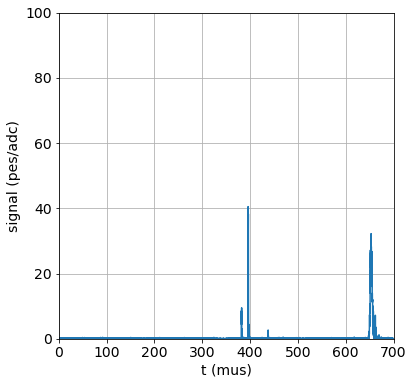

In [551]:
event=11
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

### Event

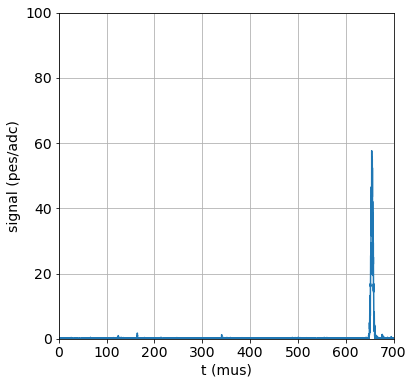

In [552]:
event=12
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

In [553]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 124.275  124.3    124.325  124.35   124.375] µs
 Time @ max energy: 124.325
 Width: 0.1 µs
 Height: 0.9838244042946815 pes
 Energy: 3.9646728693136555 pes
 Charge: 0.0 pes
 RMS: 0.03259654681619863 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 13
       Times: [ 164.1    164.125  164.15   164.175  164.2    164.225  164.25   164.275
 164.3    164.325  164.35   164.375  164.4  ] µs
       Time @ max energy: 164.125
       Width: 0.3 µs
       Height: 1.7555179098913445 pes
       Energy: 12.93653402810806 pes
       Charge: 0.0 pes
       RMS: 0.09328017816439567 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 340.45   340.475  340.5    340.525] µs
 Time @ max energy: 340.5
 Width: 0.075 µs
 Height: 1.2551143516917507 pes
 Energy: 4.216917087283813 pes
 Charge: 0.0 pes
 RMS: 0.02594077963

In [554]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 15
       Times: [ 647.88045839  648.53931732  649.60010952  650.55810863  651.55080335
 652.55467411  653.47507674  654.47364165  655.46549302  656.4812828
 657.4501622   658.34796012  659.44538713  660.38886792  661.15683429] µs
       Time @ max energy: 654.473641652347
       Width: 13.276375902561703 µs
       Height: 1993.9724311004024 pes
       Energy: 10753.214430995924 pes
       Charge: 764.2078722836386 pes
       RMS: 2.1267870104800726 µs]

In [555]:
KR.append(kr_dst(s1s, s2s, xs, ys))
KR

[KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7)),
 KrDst(es1=24.632143180461561, ws1=550.0, es2=12732.169696089704, ws2=550.0, qs2=806.98207636866016, dt=550.40813448112203, c=Cluster(Q=806.98207636866016, x=-20.280406837189968, y=53.111025479487076, nsipm=83)),
 KrDst(es1=4.2922641698837651, ws1=100.0, es2=8267.5100749920839, ws2=100.0, qs2=476.12195218014847, dt=348.9192680998305, c=Cluster(Q=476.12195218014841, x=35.619749348227387, y=96.227390320957241, nsipm=65)),
 KrDst(es1=14.326128761767084, ws1=225.0, es2=9957.6714959838191, ws2=225.0, qs2=745.6633791330878, dt=164.61142953873204, c=Cluster(Q=745.66337913308757, x=32.983391130106178, y=-180.43350651934065, nsipm=78)),
 KrDst(es1=33.509276513120163, ws1=525.0, es2=6930.0293127460127, ws2=525.0, qs2=764.20787228363861, dt=497.84401588461151, c=Cluster(Q=764.2078722836386

### Event

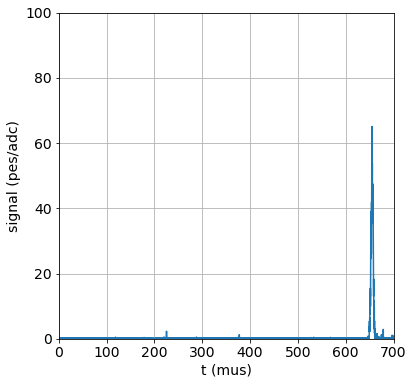

In [556]:
event=13
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

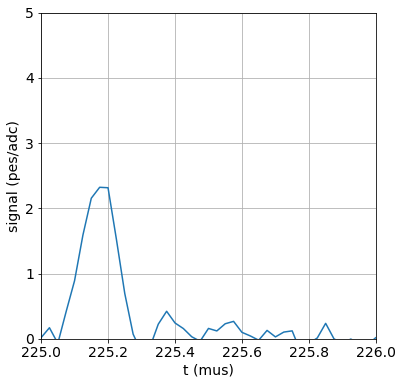

In [560]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =225,
                            t_max      = 226,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

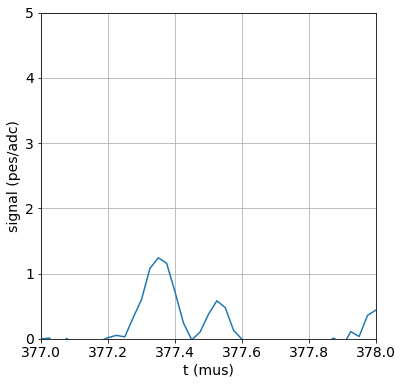

In [561]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =377,
                            t_max      = 378,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [562]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 225.1    225.125  225.15   225.175  225.2    225.225] µs
 Time @ max energy: 225.175
 Width: 0.125 µs
 Height: 2.322643332041664 pes
 Energy: 10.799359622813228 pes
 Charge: 0.0 pes
 RMS: 0.03750134341313156 µs]

In [563]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 649.60454021  650.55225075  651.52874092  652.53673985  653.5074358
 654.51750714  655.45479607  656.47200448  657.43035381  658.43059312
 659.40890675  660.35463662  661.39922723  662.03115744] µs
       Time @ max energy: 654.5175071392075
       Width: 12.426617229769356 µs
       Height: 2165.0372697291186 pes
       Energy: 11494.623191808274 pes
       Charge: 753.2493623435839 pes
       RMS: 2.1506459222845464 µs]

In [564]:
KR.append(kr_dst(s1s, s2s, xs, ys))
KR

[KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7)),
 KrDst(es1=24.632143180461561, ws1=550.0, es2=12732.169696089704, ws2=550.0, qs2=806.98207636866016, dt=550.40813448112203, c=Cluster(Q=806.98207636866016, x=-20.280406837189968, y=53.111025479487076, nsipm=83)),
 KrDst(es1=4.2922641698837651, ws1=100.0, es2=8267.5100749920839, ws2=100.0, qs2=476.12195218014847, dt=348.9192680998305, c=Cluster(Q=476.12195218014841, x=35.619749348227387, y=96.227390320957241, nsipm=65)),
 KrDst(es1=14.326128761767084, ws1=225.0, es2=9957.6714959838191, ws2=225.0, qs2=745.6633791330878, dt=164.61142953873204, c=Cluster(Q=745.66337913308757, x=32.983391130106178, y=-180.43350651934065, nsipm=78)),
 KrDst(es1=33.509276513120163, ws1=525.0, es2=6930.0293127460127, ws2=525.0, qs2=764.20787228363861, dt=497.84401588461151, c=Cluster(Q=764.2078722836386

### Event

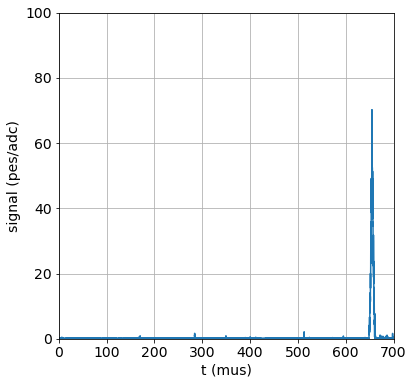

In [565]:
event=14
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

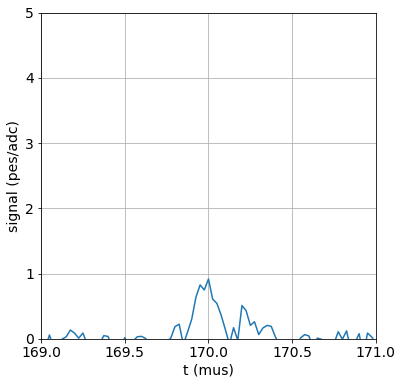

In [568]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =169,
                            t_max      = 171,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

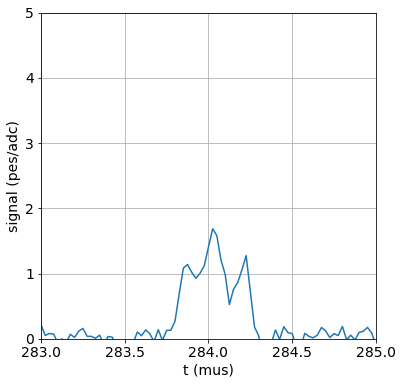

In [569]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =283,
                            t_max      = 285,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

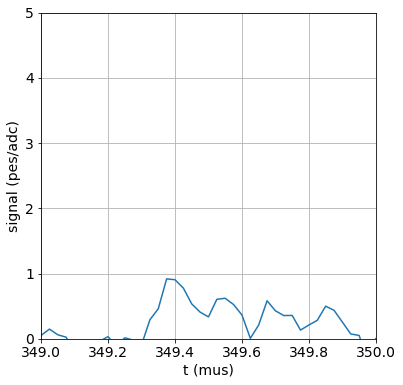

In [570]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =349,
                            t_max      = 350,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

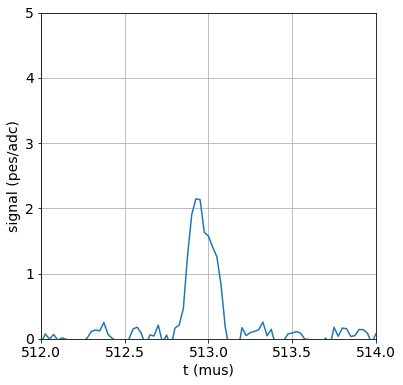

In [571]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =512,
                            t_max      = 514,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

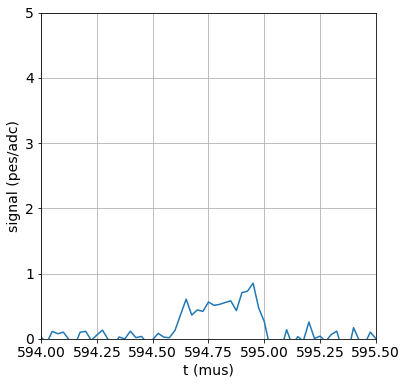

In [573]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =594,
                            t_max      = 595.5,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [574]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 648.7710672   649.51547401  650.54878203  651.53823152  652.49397391
 653.50978406  654.508531    655.47879022  656.45790057  657.46904375
 658.4059704   659.40338732  660.4826455   661.18755798] µs
       Time @ max energy: 654.508531003797
       Width: 12.416490777133149 µs
       Height: 2067.7087522390348 pes
       Energy: 11605.516915369819 pes
       Charge: 760.8614535951772 pes
       RMS: 2.2831163696671806 µs]

In [575]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 17
       Times: [ 283.85   283.875  283.9    283.925  283.95   283.975  284.     284.025
 284.05   284.075  284.1    284.125  284.15   284.175  284.2    284.225
 284.25 ] µs
       Time @ max energy: 284.025
       Width: 0.4 µs
       Height: 1.6869568719433432 pes
       Energy: 18.374195367038215 pes
       Charge: 0.0 pes
       RMS: 0.11771628848397205 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 512.875  512.9    512.925  512.95   512.975  513.     513.025  513.05 ] µs
 Time @ max energy: 512.925
 Width: 0.175 µs
 Height: 2.14660611845839 pes
 Energy: 13.329889582497557 pes
 Charge: 0.0 pes
 RMS: 0.05330858758585486 µs]

In [576]:
KR.append(kr_dst(s1s, s2s, xs, ys))
KR

[KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7)),
 KrDst(es1=24.632143180461561, ws1=550.0, es2=12732.169696089704, ws2=550.0, qs2=806.98207636866016, dt=550.40813448112203, c=Cluster(Q=806.98207636866016, x=-20.280406837189968, y=53.111025479487076, nsipm=83)),
 KrDst(es1=4.2922641698837651, ws1=100.0, es2=8267.5100749920839, ws2=100.0, qs2=476.12195218014847, dt=348.9192680998305, c=Cluster(Q=476.12195218014841, x=35.619749348227387, y=96.227390320957241, nsipm=65)),
 KrDst(es1=14.326128761767084, ws1=225.0, es2=9957.6714959838191, ws2=225.0, qs2=745.6633791330878, dt=164.61142953873204, c=Cluster(Q=745.66337913308757, x=32.983391130106178, y=-180.43350651934065, nsipm=78)),
 KrDst(es1=33.509276513120163, ws1=525.0, es2=6930.0293127460127, ws2=525.0, qs2=764.20787228363861, dt=497.84401588461151, c=Cluster(Q=764.2078722836386

### Event

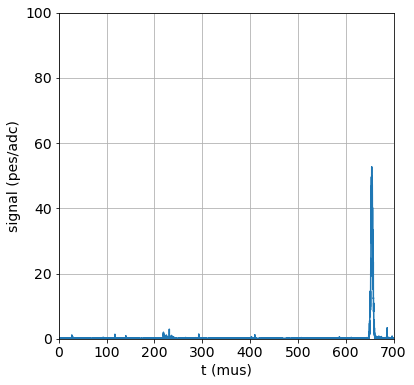

In [577]:
event=15
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

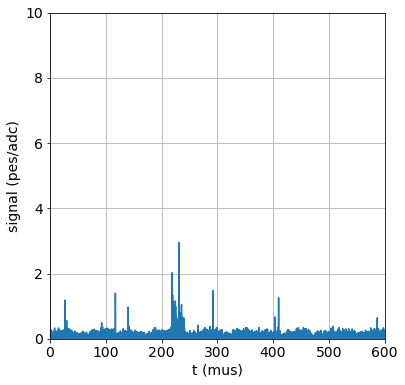

In [579]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [580]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 27.1    27.125  27.15   27.175] µs
 Time @ max energy: 27.15
 Width: 0.075 µs
 Height: 1.186333240280328 pes
 Energy: 4.155896843886839 pes
 Charge: 0.0 pes
 RMS: 0.02724246369800994 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 117.2    117.225  117.25   117.275  117.3    117.325  117.35   117.375] µs
 Time @ max energy: 117.225
 Width: 0.175 µs
 Height: 1.401433081074158 pes
 Energy: 8.362406455843303 pes
 Charge: 0.0 pes
 RMS: 0.05538004511574037 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 139.975  140.     140.025  140.05   140.075  140.1    140.125] µs
 Time @ max energy: 140.0
 Width: 0.15 µs
 Height: 0.9689863703001973 pes
 Energy: 5.692245000515783 pes
 Charge: 0.0 pes
 RMS: 0.050163508248723905 µs, 
       ---------------------
       S1 instance
       ---------------------
       Num

### Event

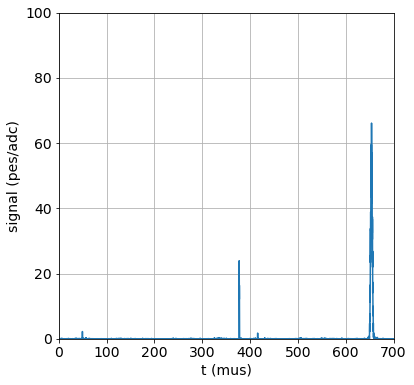

In [581]:
event=16
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

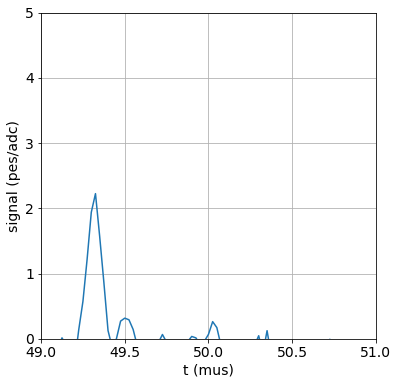

In [586]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =49,
                            t_max      = 51,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

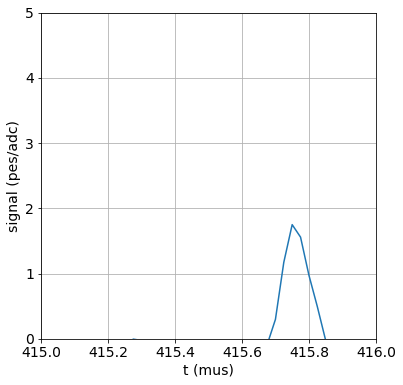

In [587]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =415,
                            t_max      = 416,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [584]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 49.275  49.3    49.325  49.35   49.375] µs
 Time @ max energy: 49.325
 Width: 0.1 µs
 Height: 2.225344646059359 pes
 Energy: 7.823950448974819 pes
 Charge: 0.0 pes
 RMS: 0.030590760732443063 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 415.725  415.75   415.775  415.8  ] µs
 Time @ max energy: 415.75
 Width: 0.075 µs
 Height: 1.750000843882254 pes
 Energy: 5.457043016224121 pes
 Charge: 0.0 pes
 RMS: 0.025399548582814374 µs]

In [583]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 10
       Times: [ 649.80265502  650.60391892  651.56321193  652.5266907   653.49973665
 654.47011036  655.43302567  656.40155574  657.31623356  658.28199549] µs
       Time @ max energy: 653.4997366455733
       Width: 8.479340469887829 µs
       Height: 2206.2455433945415 pes
       Energy: 9537.373553609616 pes
       Charge: 745.6633791330878 pes
       RMS: 1.583134399067182 µs]

### Conclusions

- Deconvolution correct
- Not clear how to select S1
- Not clear dependence of S1 light with Z
- Need to try selection including PMT counting. 
- Need to try selection on "peaky stuff" as opposed to "flat stuff"